   # ENGI-5631-FB - Signal Prcoessing In Biomedical Applications
   
   # Final Project - EEG 
   


###### Jared Mercier - $0644650$

###### Jema Sharin Panki Raj - $student ID$

###### Rushikesh Ambalal Parmar - $student ID$

       

### An Introduction to EEG 

An Electroencephalogram (EEG) is a signal processing technique which maps out the electrical activity generated from the brain. The main electrical source detected from the EEG is from the neurons located in the cerebral cortex, known as pyramidal cells. The cells are formed in a parallel arrangement which produce summed electrical dipoles that can be measured from the scalp or directly measured through an invasive surgical process. EEG’s have become a major source of diagnosis for epileptic patients.

EEG’s can measure the abnormalities present in the brain, which can correlate to the subject having a seizure.
The summed electric dipoles generated from the brain are measured using electrodes. The electric dipoles are due to the action potentials that occur in the cell membrane of the nerve cells. The action potentials that occur in the cell membrane contain voltages in the millivolt range which produce action current. The cell membrane is the main communications link to the electrodes. The electrodes detect the action current and convert it into a sinusoidal voltage signal with a specific frequency. This is the critical component for the data acquisition stage. The electrodes sense the small action potential’s generated from the brain and convert it into an electrical signal to be processed. The electrodes use a conductive gel, which reduces the impedance of the skin, since the signals emitted from the pyramidal cells must penetrate through the skin and skull, their amplitudes gets attenuated. Therefore, the electrodes detect signals typically in the 0.5µVpp - 100 µVpp range. The standard electrode arrangement is in such a fashion where they actively measure from the left, ride and center of the scalp. The following displays the electrode and its corresponding identification: Left area electrodes: Fp1, F7, F3, T3, C3, P3, T5, 01. Right area electrodes: Fp2, F8, F4, T4, C4, P4, T6, 02. Center electrodes: Fz, Cz, Pz. 

The signals acquired from the electrodes are noisy, low in amplitude and contain irrelevant information. Therefore, the signal processing or preprocessing stage occurs. Amplifier stages typically provide the next path for the EEG signal. Operational amplifiers are configured to provide large gains to the signal, remove the DC components and reduce the noise. An example of an amplifier used in EEG applications, is the average reference differential amplifier. The two inputs are the signal from one single electrode and an average of all the other signals being currently measured at that specific time. Other common types of amplifiers used are instrumentation ampifers. The signal processing stage will also contain driver circuits to improve the isolation between the signal path.

Typical brain waves exhibit relevant information in the frequency range of 2Hz - 120Hz. The frequency of brain waves is placed in specific categories as followed: Gamma (>30Hz), Beta (13-30Hz), Alpha (8-13Hz), Theta (4-8Hz), Delta (0.5-4Hz). Before the filtering occurs, the signal may or may not be passed through an A-D converter, therefore, both digital and analog filters find use in EEG applications, with the former being more common. Digital IIR or FIR filters are used to decompose the frequency bands (i.e. Gamma, Theta, etc.) before the feature extraction process occurs. Within this bandwidth there contains noise components, such as, the 60Hz power line noise, eye movement of <1Hz, and muscle movements at 70Hz>. To eliminate the power line noise, narrow band-stop filters (notch filters) are commonly used. A high pass and low pass filter can be used to eliminate the other two noise components (eye movement and muscle movement) respectively.

Once the signal has been preprocessed either in the digital or analog domain there is variety of feature extraction techniques used in EEG applications. Techniques such as the Fourier transform, wavelet transform, Hilbert transform, and power spectral density. The use of these techniques provides a better understanding of the amplitudes of the signals contained within the frequency bands. Once the feature extraction process has taken place, the EEG recordings from each individual electrode is mapped out on a monitor with its amplitude on the y-axis and time on the x-axis. A conversion from the frequency to discrete time domain will therefore occur. In modern applications, the use of D-A converters do not find that much use.
Experimental data has provided interesting insight regarding the emitted frequencies from the brain depending on the subject’s state (e.g. thinking, sleeping, relaxed, etc.). For example, when the patient is awake they will exhibit stronger beta waves. If the patient is relaxed, the frequency will drop into the alpha category. This insight provides useful for the expectation of the EEG readings. The most common hypothesis test in EEG applications is if the patient is having a seizure or not. Identifying if the patient is having a seizure can depend on the expertise of the individual performing the diagnosis, the type and severity of the seizure the patient experiences and existing EEG data of the patient. For strong epileptic episodes, noticeable spikes in amplitude of the EEG reading will be displayed throughout each electrode.

In summary, an EEG requires electrodes to acquire the desired signal generated from the brain. Then the amplification and filtering stages occur, this reduces irrelevant information and amplifies the signal. Feature extraction techniques such as the Fourier transform are used to examine the amplitudes further, which can also be useful within the filtering process, by separating the frequency bands and observing each band alone. Usually, the signal will be converted back into the time domain and displayed on a monitor. The main hypothesis test is if the subject is experiencing a seizure or not.

Below is a complete process of a signal processing stage for an acquired EEG signal.

### Data Acquistion

For the data acquistion stage, the EEG data acquired was from an online database: http://kdd.ics.uci.edu/databases/eeg/eeg.html. It was sampled at a frequency of $256Hz$ for $1$ second from $64$ electrodes. The main purpose of the data was to compare the differences in brain acitivity between controlled and alcoholic subjects. For our purposes any EEG data would be suffice. The image below displays an example of the acquired data opened in a word document. The first line indicates that this data is from the alcoholic subject. The 0 FP1 indicates that this is the first trial and the electrode being used is FP1. Ten different trials were done. The list extends beyond which is shown, the numbers 0, 1 ,2 ... end at 256 (and thats just for one electrode!). These numbers correspond to the sample number. As mentioned, 64 different electrodes were used each with specific names (i.e, CPZ, FP2, X). The names of these electrodes are shown in the code below.

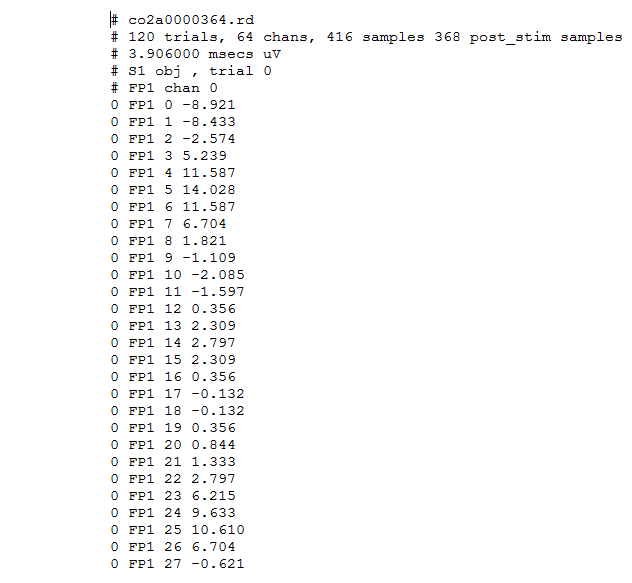

In [96]:
from IPython.display import Image
Image(filename='example.png')

In [90]:
%matplotlib inline
import scipy as Sci
import scipy.linalg
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from __future__ import division
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from IPython.display import Image


# 10 different trials
Trial = ["0","2","10","12","14","18","20","22","24","28"]

# Electrode Names (64 total)
Electrodes = [" FP1 "," FP2 "," F7 "," F8 "," AF1 "," AF2 "," FZ "," F4 "," F3 "," FC6 "," FC5 "," FC2 "," FC1 "," T8 ",
       " T7 "," CZ "," C3 "," C4 "," CP5 "," CP6 "," CP1 "," CP2 "," P3 "," P4 "," PZ "," P8 "," P7 "," PO2 ",
       " PO1 "," O2 "," O1 "," X "," AF7 "," AF8 "," F5 "," F6 "," FT7 "," FT8 "," FPZ "," FC4 "," FC3 "," C6 ",
       " C5 "," F2 "," F1 "," TP8 "," TP7 "," AFZ "," CP3 "," CP4 "," P5 "," P6 "," C1 "," C2 "," PO7 "," PO8 ",
       " FCZ "," POZ "," OZ "," P2 "," P1 "," CPZ "," nd "," Y "]

# EEG data
File = ['test1.txt','test2.txt','test3.txt','test4.txt','test5.txt',
             'test6.txt','test7.txt','test8.txt','test9.txt','test10.txt']


# Initialize 3 dimensional array with all zeros. 
q,r,s = 256, 64, 10
samples = [[[0 for x in range(q)] for y in range(r)] for z in range(s)]

# Read in the EEG data ----- z = 10 (trials), y = 64 (electrodes), x = 256 (sampls)
m = 0

# Outer loop reads in the the text files
for z in range(0,10):
    with open(File[z],'r') as f:
          dataEEG = f.readlines()
    dataEEG = [x.strip() for x in dataEEG] 
    # The text files contains 256 samples from 64 electrodes
    # Middle loop will set the electrode being sampled
    for x in range(0,64):
        # Inner loop reads the samples from 0-256
        # The first 5 (0-4) lines from the text files contain information about the patient, samples, etc.
        # The loop will start at 5 to ignore the above information as the data follows
        # The samples contain information such as: 0 FP1 0 8.2, 0 FP1 1 5.4. Where the last number is the sampled value
        # The 0 FP1 and the sample number 0, 1, 2... need to be stripped from the data. Where The first number is the 
        # trial number, the text is the name of the elecrode and the following number is the sample number.
        # After the 256 samples the text file places information about the next electrode
        # this line also needed to be removed
        for y in range(5+(257*x),261+(257*x)):
            # This line removes the trial number and the electrode name
            dataEEG[y] = dataEEG[y].replace(Trial[z]+Electrodes[x],"")
            # This line is used to remove the sample number
            n = str(y - (5 + 257*x))
            dataEEG[y] = dataEEG[y].replace(n,"")
            # A problem occurred when reading in zeros
            # The following line fixes this issue
            if dataEEG[y] == " .":
                 dataEEG[y] = 0
            # Places the needed data into the 3-Dimensional array
            # m variable was used because the innerloop started at 5, m is used to start at 0
            samples[z][x][m] = float(dataEEG[y])
            m = m + 1
            if y == (260+(257*x)):
                # resets m once all the data from any specific electrode was read
                 m = 0

Now that the data is in a three dimensional array, we can plot it. But first we have to do some averaging. The averaging needs to be done over the z-axis (explained why in the code area). This can be done by using a simple command: np.mean(data,axis). If the axis value passed is 0, it will correspond to the z-axis.

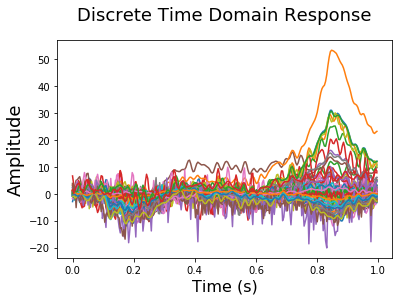

In [111]:
# Average the samples over the z-axis
# This is used to average all the samples from each text file with its corresponding sample number and electrode
# For example, the first sample from textfile1 has 0 FP1 0 some number, the next text file has 2 FP1 0 some number, etc... 
# This will average the samples sum/10.
DataEEG = np.mean(samples,axis=0)

# time axis set. 256 samples, at 256Hz (total sample period of 1s)
t = np.arange(0,256/256,1/256)
q = 256
data = [0 for x in range(q)]

# Plots each averaged electrode in the discrete time domain
for y in range(0,64):
    for x in range(0,256):
        data[x] = DataEEG[y][x]
        if x == 255:
            plt.plot(t,data[0:256])
            plt.title('Discrete Time Domain Response',fontsize=18)
            plt.xlabel('Time (s)',fontsize=16)
            plt.ylabel('Amplitude',fontsize=18)

The above graph displays all the sampled values from each electrode. For a better examination, lets just plot one.

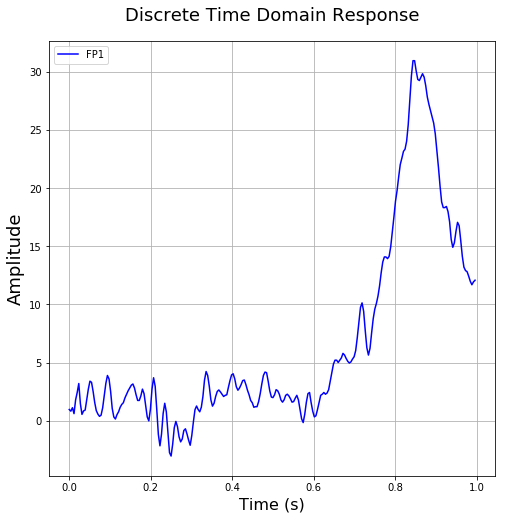

In [139]:
for y in range(0,1):
    for x in range(0,256):
        data[x] = DataEEG[y][x]
        if x == 255:
            plt.figure(figsize=(8,8))
            plt.plot(t,data[0:256],'b',label='FP1')
            plt.legend(loc='upper left')
            plt.title('Discrete Time Domain Response',fontsize=18)
            plt.xlabel('Time (s)',fontsize=16)
            plt.ylabel('Amplitude',fontsize=18)
            plt.grid()

There is large spike present in this signal. Lets do some digital signal processing before examining this further. This will include analyzing multple types of low-pass filters.

# Signal Processing (Digital Filtering)

The EEG bandwidth is relatively low (0-50Hz) so we will use a cutoff frequency of 50Hz. Lets apply some low-pass filters to our above signal (FP1) and remove that high frequency noise. But first lets discuss Butterworth, Chebyshev, and Bessel.


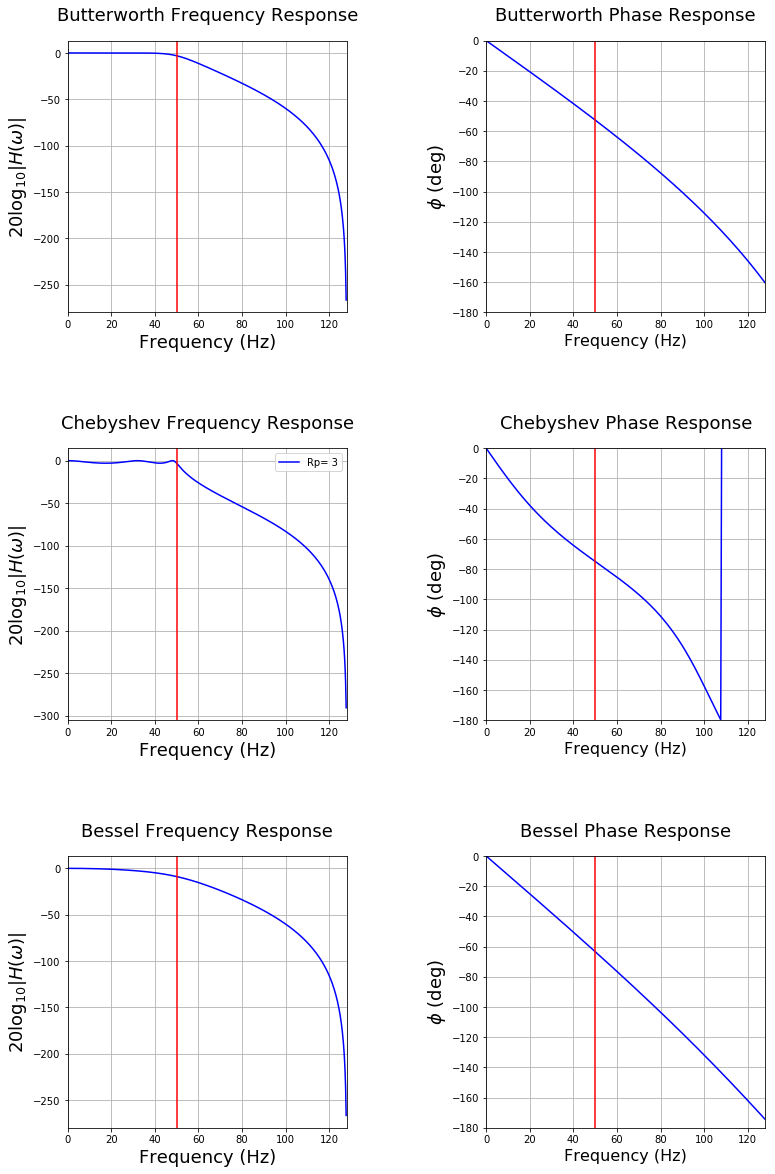

In [86]:
from matplotlib import gridspec
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt



fig=plt.figure()
fig.set_size_inches((20,20))
gs = gridspec.GridSpec(3,3)
gs.update( wspace=0.5, hspace=0.5)
ax = fig.add_subplot(plt.subplot(gs[0,0]))


# Define Normalized Cutoff Frequency for Digital Filter
fs = 256
nyq = 0.5 * fs
cutoff = 50
normal_cutoff = cutoff / nyq

#DEFINE A 5TH ORDER LOWPASS BUTTERWORTH FILTER
order = 5
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
w, h = signal.freqz(b, a)

#PLOT THE MAGNITUDE RESPONSE OF 5TH ORDER BUTTERWORTH FILTER
ax = fig.add_subplot(plt.subplot(gs[0,0]))
plt.plot(0.5*fs*w/np.pi, 20*np.log10(abs(h)), 'b')
plt.axvline(cutoff, color='r')
plt.xlim(0, 0.5*fs)
plt.title('Butterworth Frequency Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel(r"$ 20 \log_{10}|H(\omega)| $",fontsize=18)
plt.grid()


#PLOT THE PHASE RESPONSE OF 5TH ORDER BUTTERWORTH FILTER
ax = fig.add_subplot(plt.subplot(gs[0,1]))
plt.plot(0.5*fs*w,np.angle(h)/np.pi*180,'b')
plt.title('Butterworth Phase Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=16)
plt.ylabel(r"$\phi $ (deg)",fontsize=18)
plt.xlim(0, 0.5*fs)
plt.axvline(cutoff, color='r')
plt.ylim(ymin=-180,ymax=0)
plt.grid()


#DEFINE 5TH ORDER CHEBYSHEV TYPE 1 FILTER With MAX RIPPLE = 3
b, a = signal.cheby1(5,rp=3,Wn=normal_cutoff, btype='low', analog=False)
w, h = signal.freqz(b, a)

#PLOT THE MAGNITUDE RESPONSE OF 5TH ORDER CHEBYSHEV FILTER
ax = fig.add_subplot(plt.subplot(gs[1,0]))
plt.plot(0.5*fs*w/np.pi, 20*np.log10(abs(h)), 'b',label='Rp= 3')
plt.legend(loc='upper right')
plt.axvline(cutoff, color='r')
plt.xlim(0, 0.5*fs)
plt.title('Chebyshev Frequency Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel(r"$ 20 \log_{10}|H(\omega)| $",fontsize=18)
plt.grid()


#PLOT THE PHASE RESPONSE OF 5TH ORDER CHEBYSHEV FILTER
ax = fig.add_subplot(plt.subplot(gs[1,1]))
plt.plot(0.5*fs*w,np.angle(h)/np.pi*180,'b')
plt.title('Chebyshev Phase Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=16)
plt.ylabel(r"$\phi $ (deg)",fontsize=18)
plt.xlim(0, 0.5*fs)
plt.axvline(cutoff, color='r')
plt.ylim(ymin=-180,ymax=0)
plt.grid()


# DEFINE 5TH ORDER BESSEL FILTER
b, a = signal.bessel(5,Wn=low, btype='lowpass', analog=False)
w, h = signal.freqz(b, a)

#PLOT THE MAGNITUDE RESPONSE OF 5TH ORDER BESSEL FILTER
ax = fig.add_subplot(plt.subplot(gs[2,0]))
plt.plot(0.5*fs*w/np.pi, 20*np.log10(abs(h)), 'b')
plt.axvline(cutoff, color='r')
plt.xlim(0, 0.5*fs)
plt.title('Bessel Frequency Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel(r"$ 20 \log_{10}|H(\omega)| $",fontsize=18)
plt.grid()


#PLOT THE PHASE RESPONSE OF 5TH ORDER BESSEL FILTER
ax = fig.add_subplot(plt.subplot(gs[2,1]))
plt.plot(0.5*fs*w,np.angle(h)/np.pi*180,'b')
plt.title('Bessel Phase Response',fontsize=18)
plt.xlabel('Frequency (Hz)',fontsize=16)
plt.ylabel(r"$\phi $ (deg)",fontsize=18)
plt.xlim(0, 0.5*fs)
plt.axvline(cutoff, color='r')
plt.ylim(ymin=-180,ymax=0)
plt.grid()

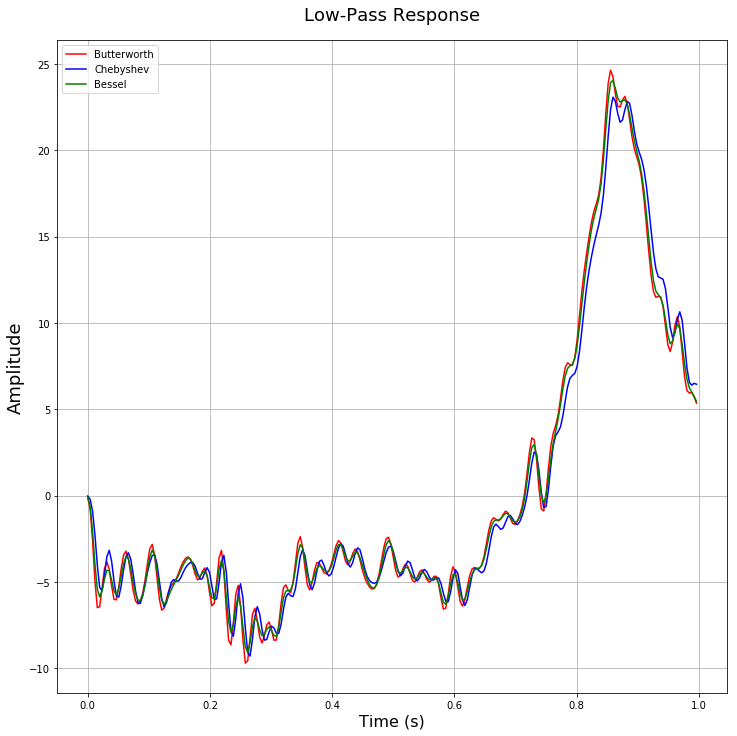

In [144]:
t = np.arange(0,256/256,1/256)
input_sig = data[0:256]-np.mean(data[0:256])


b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
d, c = signal.cheby1(5,rp=3,Wn=normal_cutoff, btype='low', analog=False)
f, e = signal.bessel(5,Wn=low, btype='lowpass', analog=False)


plt.figure(figsize=(12,12))
plt.title('Low-Pass Response',fontsize=18)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Amplitude',fontsize=18)

output_sig_but = signal.lfilter(b,a,input_sig)
plt.plot(t,output_sig_but,'r',label='Butterworth')
plt.legend(loc='upper left')
plt.grid()

output_sig_cheb = signal.lfilter(d,c,input_sig)
plt.plot(t,output_sig_cheb,'b',label='Chebyshev')
plt.legend(loc='upper left')
plt.grid()

output_sig_bess = signal.lfilter(f,e,input_sig)
plt.plot(t,output_sig_bess,'g',label='Bessel')
plt.legend(loc='upper left')
plt.grid()

Lets examine the frequency domain of the filtered signal before deciding which filter will be used in the feature extraction stage.

Summed Amplitudes from Butterworth filter: 17.5101996317
Summed Amplitudes from Chebyshev filter: 16.8338565612
Summed Amplitudes from Bessel filter: 16.7126722534


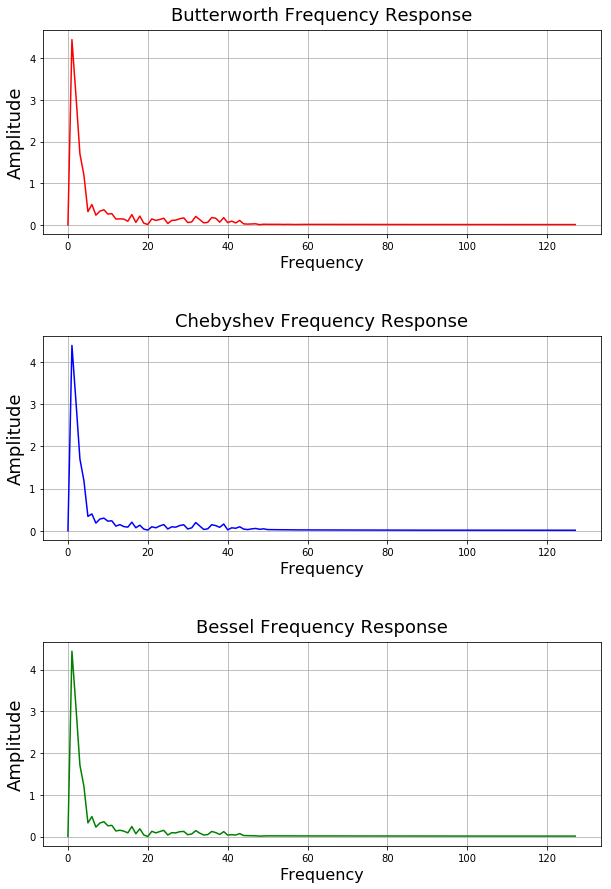

In [175]:
dataF=output_sig_but-np.mean(output_sig_but)
f=np.arange(0,128,1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

total0 = 0
total1 = 0
total2 = 0


fig=plt.figure()
fig.set_size_inches((10,15))
gs = gridspec.GridSpec(3,1)
gs.update(hspace=0.5)

rcParams['axes.titlepad'] = 10 

ax = fig.add_subplot(plt.subplot(gs[0,0]))
dataF=output_sig_but-np.mean(output_sig_but)
Y=np.fft.fft(dataF)
L=len(dataF)
Filtered_but=abs(Y)/L
for x in range (0,128):
    total0 = Filtered_but[x]+total0
plt.plot(f,Filtered_but[0:128],'r')
plt.title('Butterworth Frequency Response',fontsize=18)
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Amplitude',fontsize=18)
plt.grid()



ax = fig.add_subplot(plt.subplot(gs[1,0]))
dataF=output_sig_cheb-np.mean(output_sig_cheb)
f=np.arange(0,128,1)
Y=np.fft.fft(dataF)
L=len(dataF)
Filtered_cheb=abs(Y)/L
for x in range (0,128):
    total1 = Filtered_cheb[x]+total1
plt.plot(f,Filtered_cheb[0:128],'b')
plt.title('Chebyshev Frequency Response',fontsize=18)
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Amplitude',fontsize=18)
plt.grid()


ax = fig.add_subplot(plt.subplot(gs[2,0]))
dataF=output_sig_bess-np.mean(output_sig_bess)
f=np.arange(0,128,1)
Y=np.fft.fft(dataF)
L=len(dataF)
Filtered_bess=abs(Y)/L
for x in range (0,128):
    total2 = Filtered_bess[x]+total2
plt.plot(f,Filtered_bess[0:128],'g')
plt.title('Bessel Frequency Response',fontsize=18)
plt.xlabel('Frequency',fontsize=16)
plt.ylabel('Amplitude',fontsize=18)
plt.grid()

total0 = str(total0)
total1 = str(total1)
total2 = str(total2)

print('Summed Amplitudes from Butterworth filter: ' +total0)
print('Summed Amplitudes from Chebyshev filter: ' +total1)
print('Summed Amplitudes from Bessel filter: ' +total2)

Since the Bessel filter has less energy in the output signal, we will use it to filter the rest of our data. Now lets filter the high frequency data from our EEG signal.

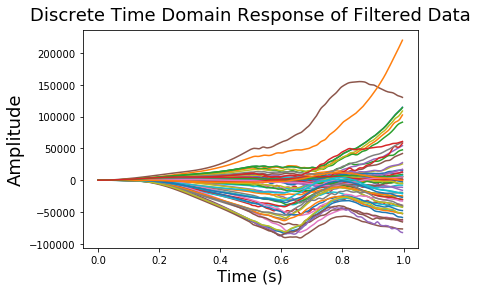

In [191]:
t = np.arange(0,256/256,1/256)

for y in range(0,64):
    for x in range(0,256):
        data[x] = DataEEG[y][x]
        if x == 255:
            output_sig_bess = signal.lfilter(f,e,data)
            plt.plot(t,output_sig_bess[0:256])
            plt.title('Discrete Time Domain Response of Filtered Data',fontsize=18)
            plt.xlabel('Time (s)',fontsize=16)
            plt.ylabel('Amplitude',fontsize=18)


# Feature Extraction

For the feature extraction lets use one of the most powerful signal analysis techniques, the Discrete Fourier Transform (DFT). The DFT is given by the following equation:

$$ A_k=\sum_{m=0}^{n-1}a_m \exp \left(-2\pi i \frac{mk}{n} \right ) [k=0,...,n-1] $$

Trying to determine a recurring property of a noisy signal is difficult, the DFT is able to fix that issue by converting the time domain into the frequency domain. Any time interval within the orginal signal that could be subjected to noise will be hard to differentiate. This allows you to extract its hidden properities by applying a 'weight' to some time interval in the signal and the more the interval occurs, the higher the 'weight' will be. Lets now apply the DFT to our signal.

The electrode detecting a majority of the applied stimulus: X 


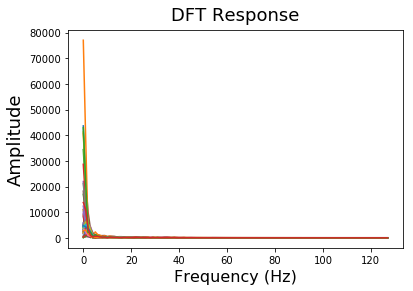

In [189]:
max_value = []
for y in range(0,64):
    for x in range(0,256):
        data[x] = DataEEG[y][x]
        if x == 255:
            data = data-np.mean(data)
            output_sig_bess = signal.lfilter(f,e,data)
            L=len(output_sig_bess) 
            Y=np.fft.fft(output_sig_bess)
            DFT=abs(Y)/L
            max_value.append(np.max(DFT))
            f=np.arange(0,128,1)
            plt.plot(f, DFT[0:128]) 
            plt.title('DFT Response',fontsize=18)
            plt.xlabel('Frequency (Hz)',fontsize=16)
            plt.ylabel('Amplitude',fontsize=18)

The signal contains large peaks within the the bandwidth of 0Hz-10Hz range. And as you can see, the higher frequencies have been completed removed. 

# Hypothesis Testing

To determine which electrode measured a majority of the energy from the stimulus will simply be done by taking the max value. This is done by the following line.

In [190]:
print('The electrode detecting a majority of the applied stimulus:'+Electrodes[max_value.index(max(max_value))])

The electrode detecting a majority of the applied stimulus: X 
